# AutoStyleTransfer Demo

## Setup

In [1]:
# Autoreloading makes development easier
%load_ext autoreload
%autoreload 2

In [2]:
# Import libraries
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras as krs
from tools.audio_tools import read_audio, write_audio, play_audio
from tools.feature_tools import compute_mels, compute_imels, normalize_features, denormalize_features
from tools.plot_tools import make_figax, plot_history, plot_audio, plot_spectral_feature
from tools.constants import n_secs, default_sample_rate
os.makedirs("./demo/figures", exist_ok=True)

2023-12-12 12:03:17.102476: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-12-12 12:03:17.140258: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-12 12:03:17.140295: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-12 12:03:17.140321: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-12 12:03:17.147751: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-12-12 12:03:17.148426: I tensorflow/core/platform/cpu_feature_guard.cc:182] This Tens

## Data Loading

In [3]:
# Read audio samples
classical_audio = read_audio("./demo/classical.wav")
jazz_audio = read_audio("./demo/jazz.wav")

print(f"{classical_audio.shape = }")
print(f"{jazz_audio.shape = }")

classical_audio.shape = (16252416,)
jazz_audio.shape = (11309048,)


In [4]:
def preprocess(audio):
    # Equalize loadness
    current_rms = np.sqrt(np.mean(audio**2))
    target_rms = 10**(-20/20)
    audio_normalized = audio * target_rms / current_rms

    # Cut into segments
    samples_per_segment = int(default_sample_rate * n_secs)
    samples_per_segment = 2**round(np.log2(samples_per_segment))
    n_segments = int(len(audio_normalized) / samples_per_segment)
    audio_segments = [None] * n_segments
    for i in range(n_segments):
        segment = audio_normalized[i*samples_per_segment:(i+1)*samples_per_segment]
        audio_segments[i] = segment
    return np.array(audio_segments)

In [5]:
# Cut audio into segments
classical_cuts = preprocess(classical_audio)
jazz_cuts = preprocess(jazz_audio)

n_classical_cuts = classical_cuts.shape[0]
n_jazz_cuts = jazz_cuts.shape[0]

print(f"{classical_cuts.shape = }")
print(f"{jazz_cuts.shape = }")

classical_cuts.shape = (123, 131072)
jazz_cuts.shape = (86, 131072)


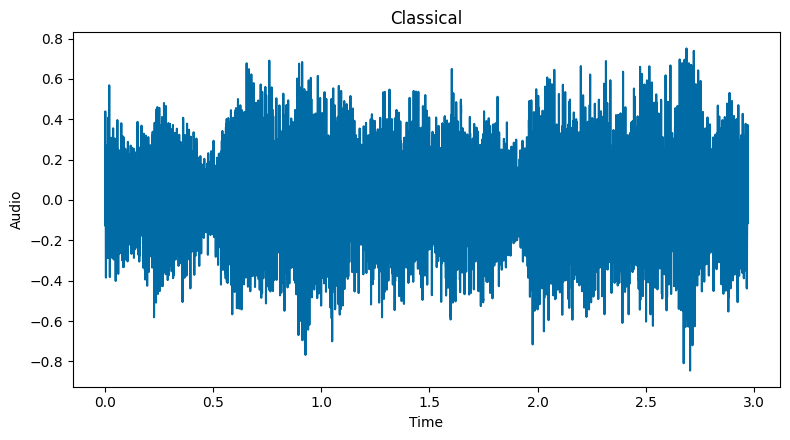

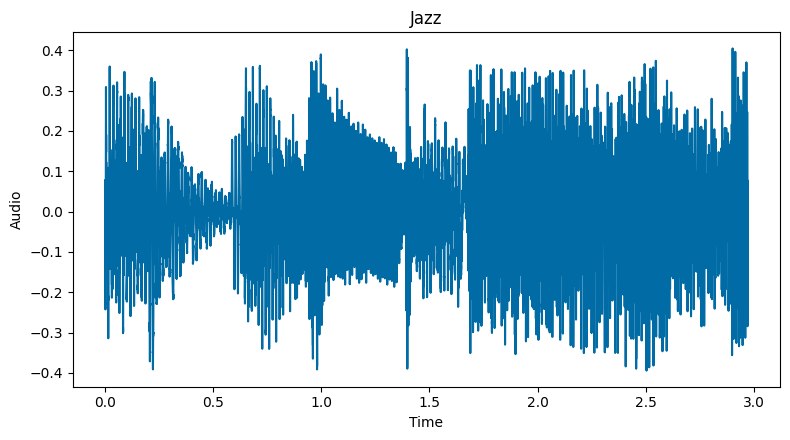

In [6]:
# Plot examples
classical_i = np.random.randint(n_classical_cuts)
classical_cut_eg = classical_cuts[classical_i]
fig, ax = plot_audio(classical_cut_eg)
ax.set_title("Classical")
fig.tight_layout()
fig.savefig(os.path.join("demo", "figures", "classical_cut.png"), dpi=300, facecolor="white")
jazz_i = np.random.randint(n_jazz_cuts)
jazz_cut_eg = jazz_cuts[jazz_i]
fig, ax = plot_audio(jazz_cut_eg)
ax.set_title("Jazz")
fig.tight_layout()
fig.savefig(os.path.join("demo", "figures", "jazz_cut.png"), dpi=300, facecolor="white")
plt.show()

## Feature Extraction

In [7]:
# Compute mel spectrum
classical_mels = np.expand_dims(np.array([compute_mels(classical_cut) for classical_cut in classical_cuts]), axis=3)
jazz_mels = np.expand_dims(np.array([compute_mels(jazz_cut) for jazz_cut in jazz_cuts]), axis=3)

print(f"{classical_mels.shape = }")
print(f"{jazz_mels.shape = }")

classical_mels.shape = (123, 259, 256, 1)
jazz_mels.shape = (86, 259, 256, 1)


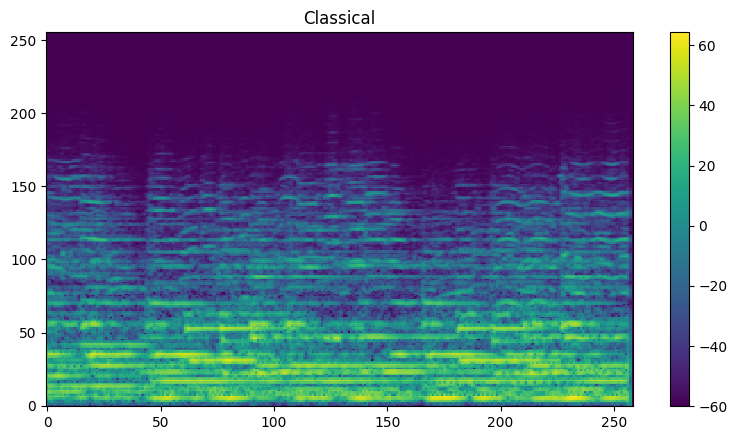

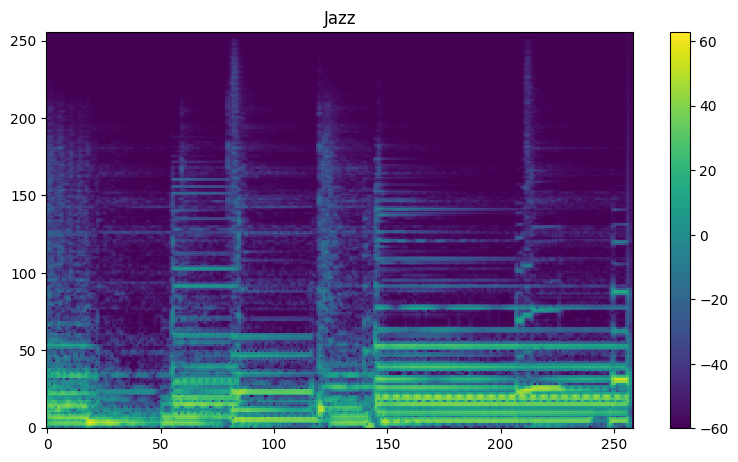

In [8]:
# Plot examples
classical_mel_eg = classical_mels[classical_i]
fig, ax = plot_spectral_feature(classical_mel_eg)
ax.set_title("Classical")
fig.tight_layout()
fig.savefig(os.path.join("demo", "figures", "classical_mels.png"), dpi=300, facecolor="white")
jazz_mel_eg = jazz_mels[jazz_i]
fig, ax = plot_spectral_feature(jazz_mel_eg)
fig.tight_layout()
fig.savefig(os.path.join("demo", "figures", "jazz_mels.png"), dpi=300, facecolor="white")
ax.set_title("Jazz")
plt.show()

In [9]:
# Normalize features
X_c = normalize_features(classical_mels, name="classical")
X_j = normalize_features(jazz_mels, name="jazz")

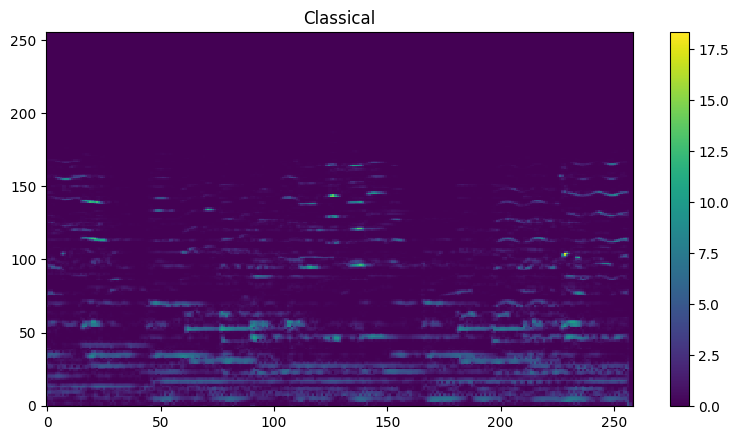

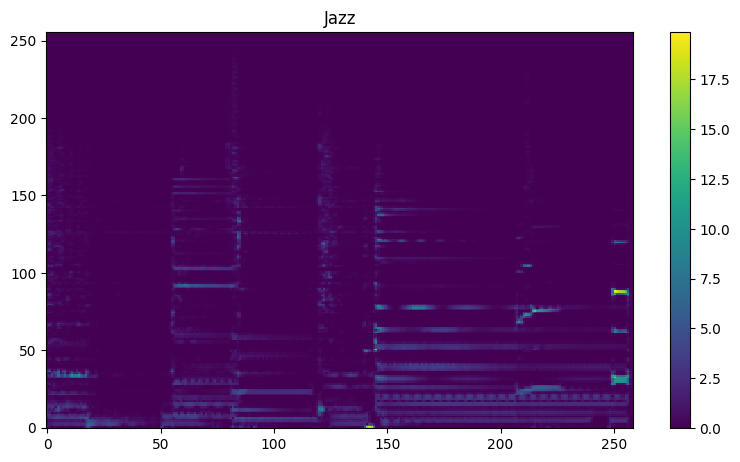

In [10]:
# Plot examples
X_c_eg = X_c[classical_i]
fig, ax = plot_spectral_feature(X_c_eg, fn=None)
ax.set_title("Classical")
fig.tight_layout()
fig.savefig(os.path.join("demo", "figures", "X_c.png"), dpi=300, facecolor="white")
X_j_eg = X_j[jazz_i]
fig, ax = plot_spectral_feature(X_j_eg, fn=None)
fig.tight_layout()
fig.savefig(os.path.join("demo", "figures", "X_j.png"), dpi=300, facecolor="white")
ax.set_title("Jazz")
plt.show()

## Style Transfer

In [49]:
from models.demo_models import models, input_shape
for i, model in enumerate(models):
    print(f"{i}: {model['label']}")

0: Convolutional Transcoder
1: Variational Transcoder
2: GAN Transcoder with AdaIN
3: Variational GAN Transcoder with AdaIN
4: GAN Transcoder with Learnable Style Code
5: Variational GAN Transcoder with Learnable Style Code


In [60]:
# Pick a model
i = 5
model = models[i]

In [61]:
# Load model
model_label = model["label"]

print(f"Loading model {model_label}")
model_params = model["params"]
transcoder = model["create_model"](**model_params)
transcoder.load_weights(model["path"])

Loading model Variational GAN Transcoder with Learnable Style Code
conv_channels = array([2, 4])
conv_output_size = 1044
mlp_sizes = array([32,  1])
conv_channels = array([2, 4])
conv_output_size = 1044
mlp_sizes = array([32,  1])


In [62]:
print(f"Performing style transfer")
X_c_hat = transcoder.selfcode(X_c, XtoX = True)
X_j_fake = transcoder.transcode(X_c, XtoY = True)
X_j_hat = transcoder.selfcode(X_j, XtoX = False)
X_c_fake = transcoder.transcode(X_j, XtoY = False)

Performing style transfer


Plotting examples


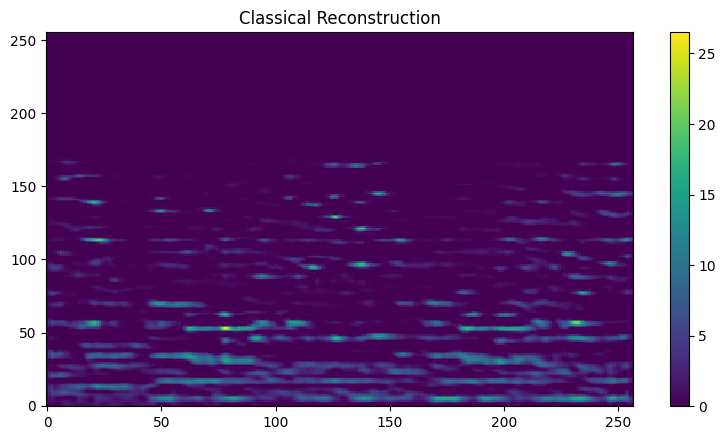

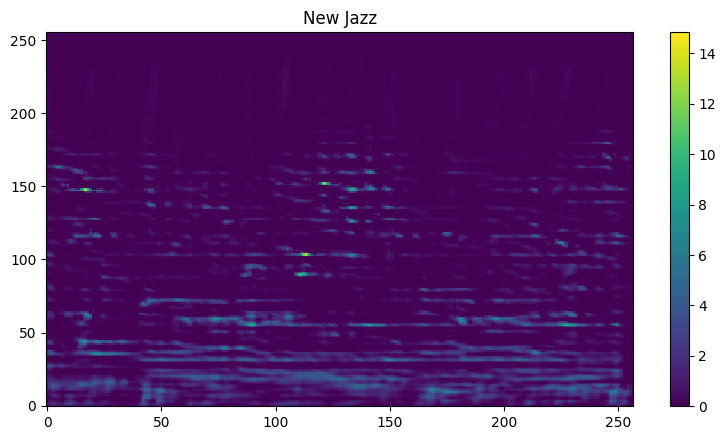

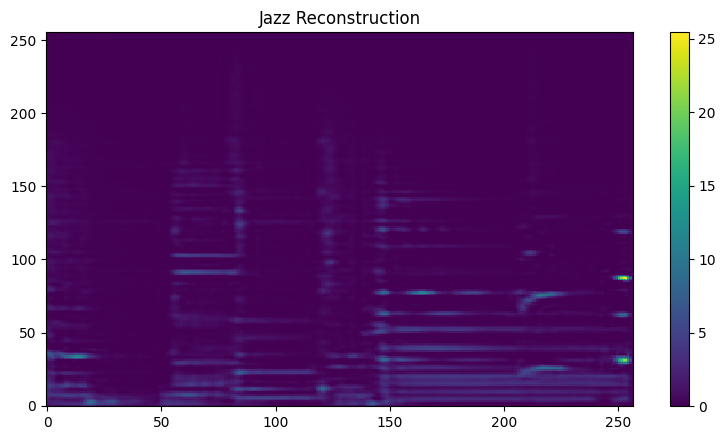

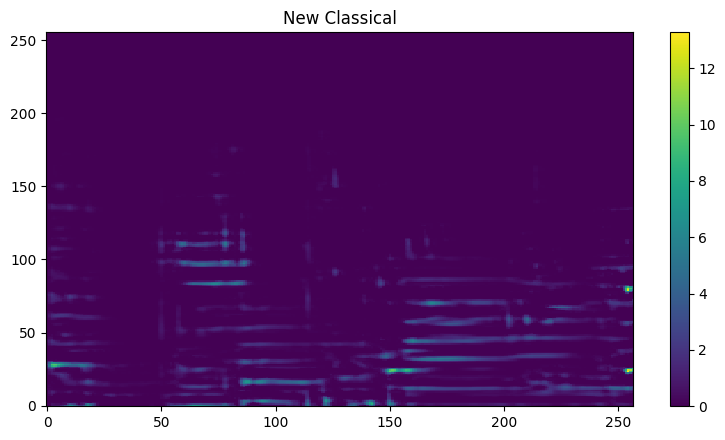

In [63]:
# Plot examples
print("Plotting examples")
## Classical
fig, ax = plot_spectral_feature(X_c_hat[classical_i], fn=None)
ax.set_title("Classical Reconstruction")
fig.tight_layout()
fig.savefig(os.path.join("demo", "figures", "X_c_hat.png"), dpi=300, facecolor="white")
fig, ax = plot_spectral_feature(X_j_fake[classical_i], fn=None)
ax.set_title("New Jazz")
fig.tight_layout()
fig.savefig(os.path.join("demo", "figures", "X_j_fake.png"), dpi=300, facecolor="white")
## Jazz
fig, ax = plot_spectral_feature(X_j_hat[jazz_i], fn=None)
ax.set_title("Jazz Reconstruction")
fig.tight_layout()
fig.savefig(os.path.join("demo", "figures", "X_j_hat.png"), dpi=300, facecolor="white")
fig, ax = plot_spectral_feature(X_c_fake[jazz_i], fn=None)
ax.set_title("New Classical")
fig.tight_layout()
fig.savefig(os.path.join("demo", "figures", "X_c_fake.png"), dpi=300, facecolor="white")

In [64]:
# Denormalize features
print("Denormalizing")
classical_hat_mels = denormalize_features(X_c_hat, name="classical")
jazz_fake_mels = denormalize_features(X_j_fake, name="jazz")
jazz_hat_mels = denormalize_features(X_j_hat, name="jazz")
classical_fake_mels = denormalize_features(X_c_fake, name="classical")

Denormalizing


Plotting examples


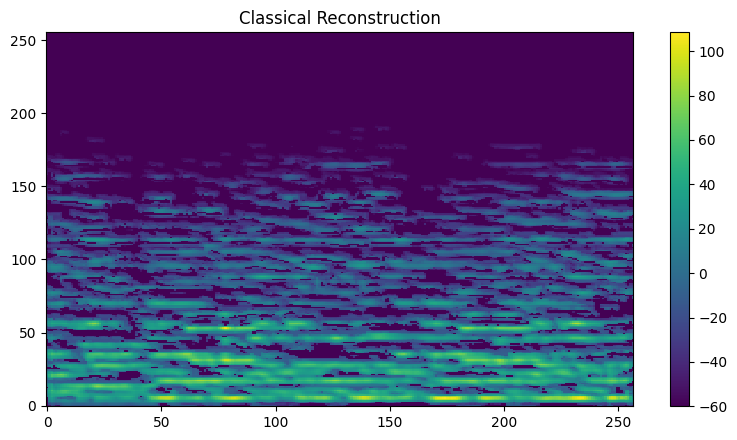

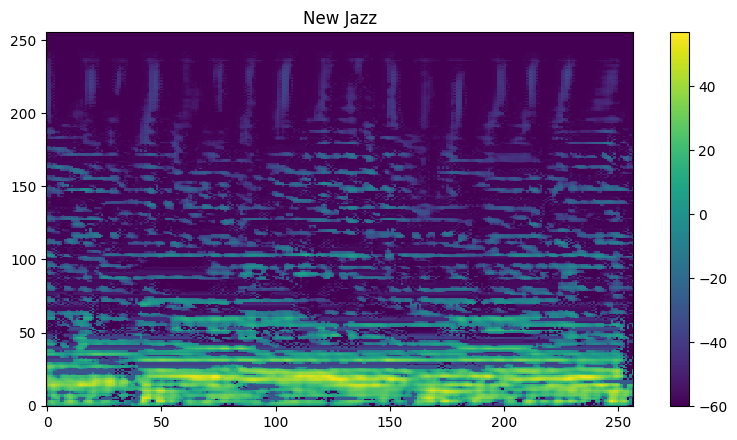

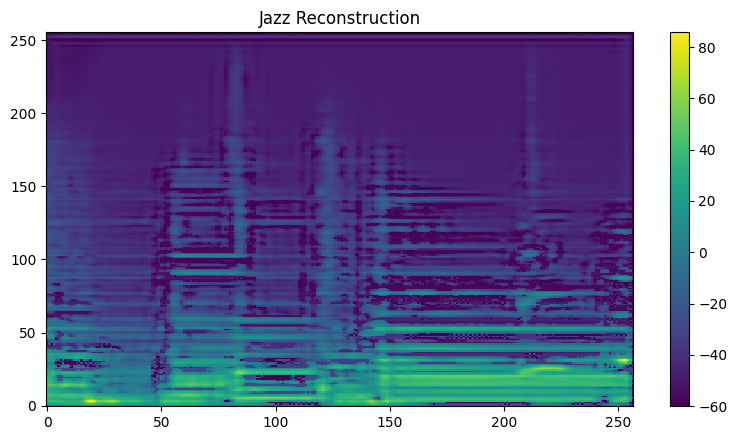

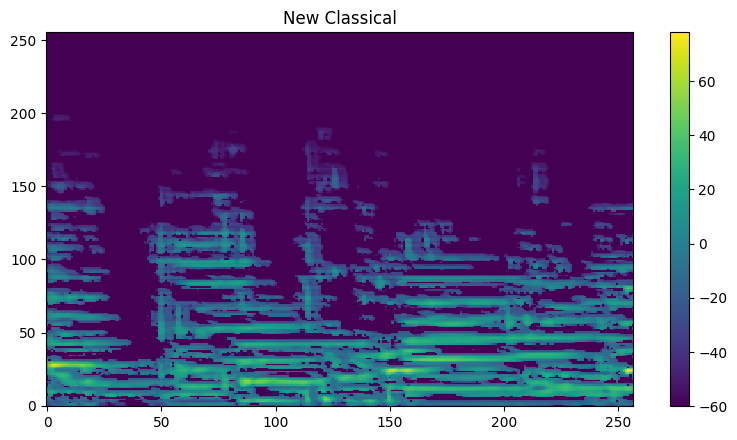

In [65]:
# Plot examples
print("Plotting examples")
## Classical
fig, ax = plot_spectral_feature(classical_hat_mels[classical_i])
ax.set_title("Classical Reconstruction")
fig.tight_layout()
fig.savefig(os.path.join("demo", "figures", "classical_hat_mels.png"), dpi=300, facecolor="white")
fig, ax = plot_spectral_feature(jazz_fake_mels[classical_i])
ax.set_title("New Jazz")
fig.tight_layout()
fig.savefig(os.path.join("demo", "figures", "jazz_fake_mels.png"), dpi=300, facecolor="white")
## Jazz
fig, ax = plot_spectral_feature(jazz_hat_mels[jazz_i])
ax.set_title("Jazz Reconstruction")
fig.tight_layout()
fig.savefig(os.path.join("demo", "figures", "jazz_hat_mels.png"), dpi=300, facecolor="white")
fig, ax = plot_spectral_feature(classical_fake_mels[jazz_i])
ax.set_title("New Classical")
fig.tight_layout()
fig.savefig(os.path.join("demo", "figures", "classical_fake_mels.png"), dpi=300, facecolor="white")

In [66]:
# Reconstruct audio
print("Reconstructing audio")
print("0%")
classical_hat_cuts = np.squeeze(np.array([compute_imels(mels) for mels in classical_hat_mels]))
print("25%")
jazz_fake_cuts = np.squeeze(np.array([compute_imels(mels) for mels in jazz_fake_mels]))
print("50%")
jazz_hat_cuts = np.squeeze(np.array([compute_imels(mels) for mels in jazz_hat_mels]))
print("75%")
classical_fake_cuts = np.squeeze(np.array([compute_imels(mels) for mels in classical_fake_mels]))
print("100%")

Reconstructing audio
0%
25%
50%
75%
100%


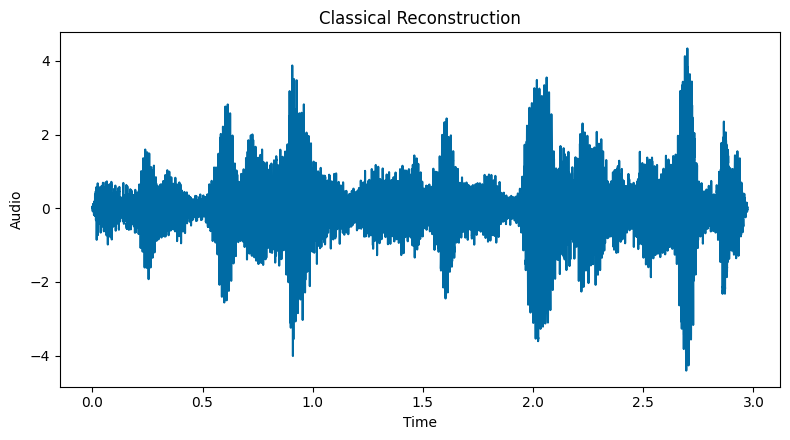

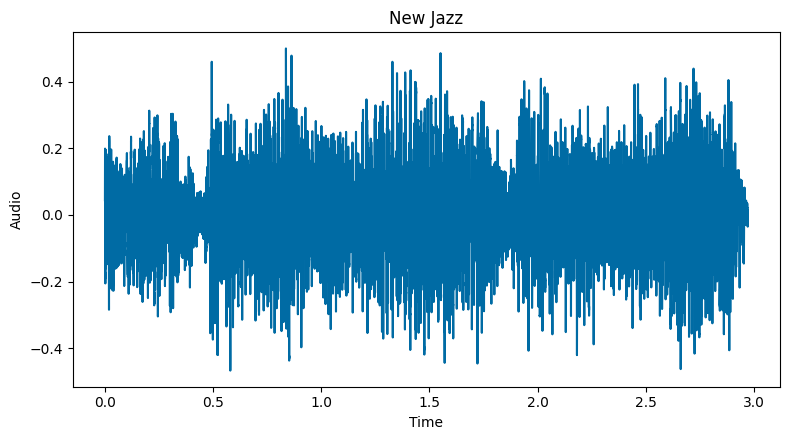

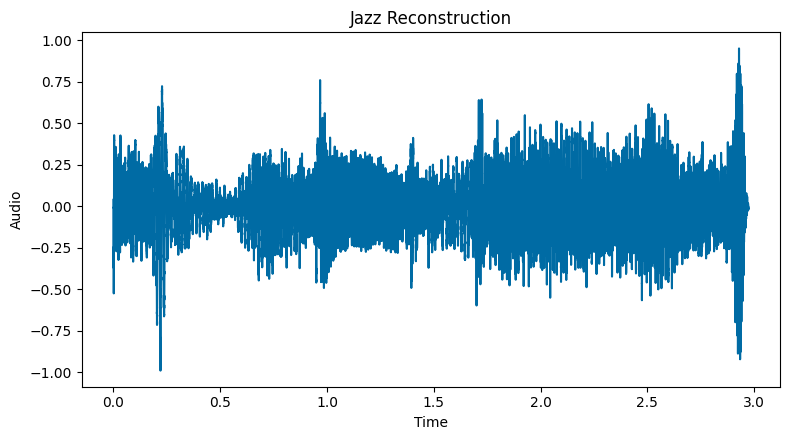

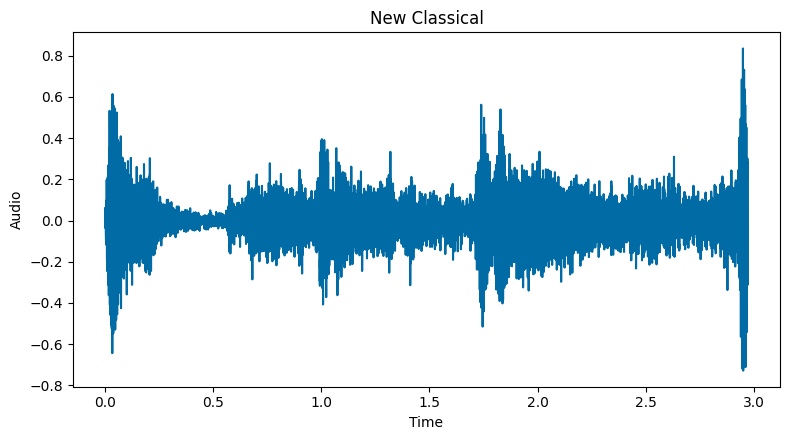

In [67]:
# Plot examples
fig, ax = plot_audio(classical_hat_cuts[classical_i])
ax.set_title("Classical Reconstruction")
fig.tight_layout()
fig.savefig(os.path.join("demo", "figures", "classical_hat_cut.png"), dpi=300, facecolor="white")
fig, ax = plot_audio(jazz_fake_cuts[classical_i])
ax.set_title("New Jazz")
fig.tight_layout()
fig.savefig(os.path.join("demo", "figures", "jazz_fake_cut.png"), dpi=300, facecolor="white")
fig, ax = plot_audio(jazz_hat_cuts[jazz_i])
ax.set_title("Jazz Reconstruction")
fig.tight_layout()
fig.savefig(os.path.join("demo", "figures", "jazz_hat_cut.png"), dpi=300, facecolor="white")
fig, ax = plot_audio(classical_fake_cuts[jazz_i])
ax.set_title("New Classical")
fig.tight_layout()
fig.savefig(os.path.join("demo", "figures", "classical_fake_cut.png"), dpi=300, facecolor="white")
plt.show()

In [68]:
# Joining audio
print("Joining audio")
classical_hat_audio = np.reshape(classical_hat_cuts, -1)
jazz_fake_audio = np.reshape(jazz_fake_cuts, -1)
jazz_hat_audio = np.reshape(jazz_hat_cuts, -1)
classical_fake_audio = np.reshape(classical_fake_cuts, -1)

Joining audio


In [69]:
# Writing audio
write_audio(classical_hat_audio, f"./demo/classical_hat_{model_label.lower().replace(' ', '_')}.wav")
write_audio(jazz_fake_audio, f"./demo/jazz_fake_{model_label.lower().replace(' ', '_')}.wav")
write_audio(jazz_hat_audio, f"./demo/jazz_hat_{model_label.lower().replace(' ', '_')}.wav")
write_audio(classical_fake_audio, f"./demo/classical_fake_{model_label.lower().replace(' ', '_')}.wav")
